# Проект: Компьютерное зрение

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

•	Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

•	Контролировать добросовестность кассиров при продаже алкоголя.


Нужно построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.


# Определение возраста покупателей

## Исследовательский анализ данных

Проведем исследовательский анализ данных:

•	Посмотрим на размер выборки.

•	Построим график распределения возраста в выборке.

•	Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import load_img

In [2]:
# Загрузка данных
labels = pd.read_csv('/datasets/faces/labels.csv')

# Посмотрим на размер выборки и несколько строк
print(f"Размер выборки: {labels.shape[0]}")  # Количество фотографий
print(labels.head())

Размер выборки: 7591
    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17


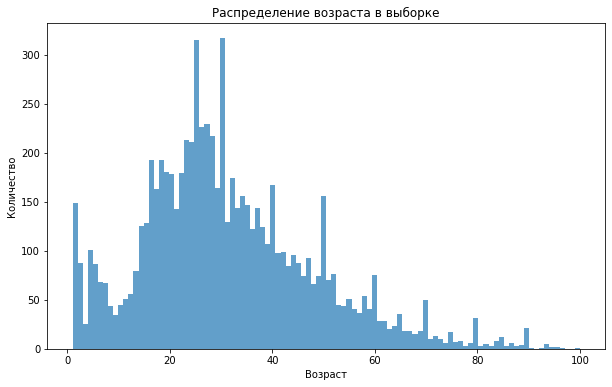

In [3]:
# Построим распределение возраста
plt.figure(figsize=(10, 6))
labels['real_age'].hist(bins=100, alpha=0.7)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid()
plt.show()

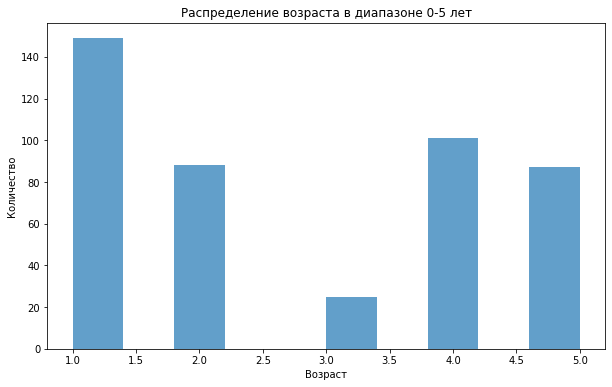

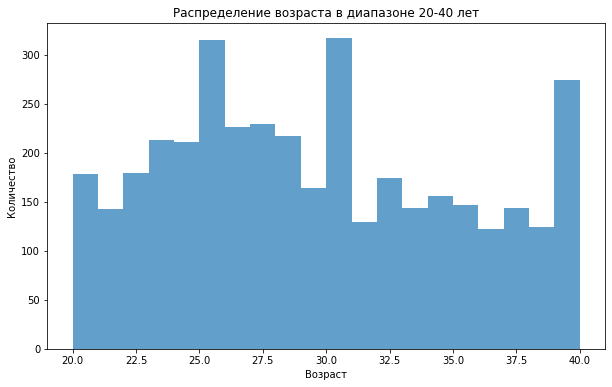

In [6]:
# Диапазон 0-5 лет
plt.figure(figsize=(10, 6))
labels_0_5 = labels[(labels['real_age'] >= 0) & (labels['real_age'] <= 5)]
labels_0_5['real_age'].hist(bins=10, alpha=0.7)   # Можно уменьшить количество столбцов, если данных мало
plt.title('Распределение возраста в диапазоне 0-5 лет')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid()
plt.show()

# Диапазон 30-40 лет
plt.figure(figsize=(10, 6))
labels_30_40 = labels[(labels['real_age'] >= 20) & (labels['real_age'] <= 40)]
labels_30_40['real_age'].hist(bins=20, alpha=0.7)  # По одному столбцу на возраст
plt.title('Распределение возраста в диапазоне 20-40 лет')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.grid()
plt.show()


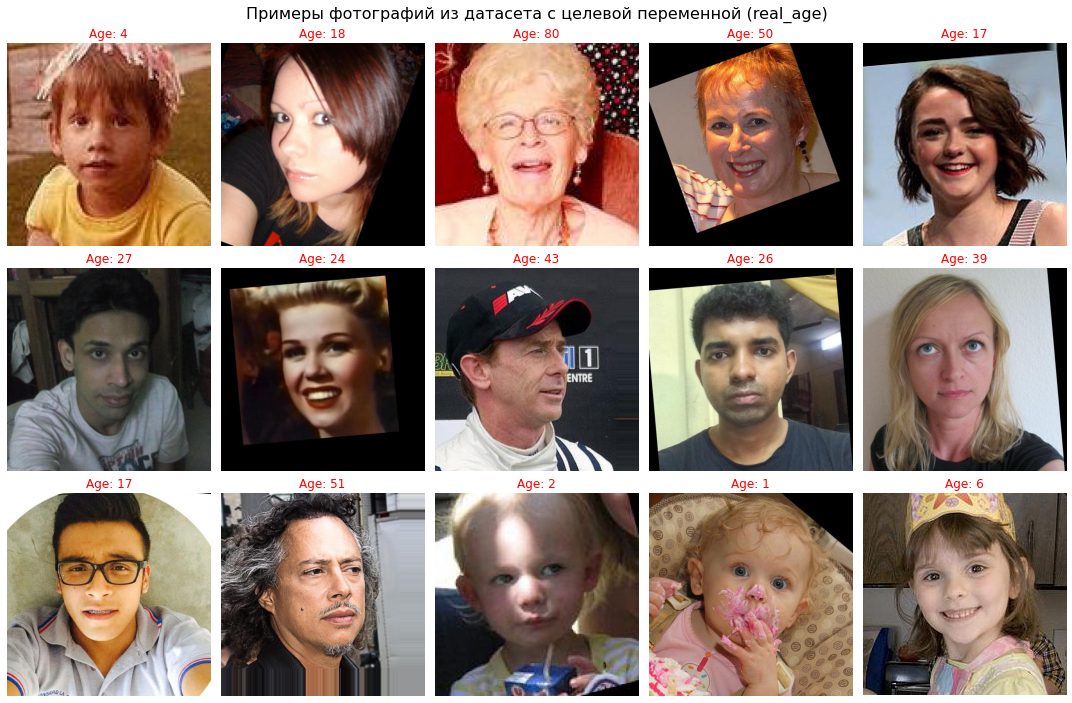

In [5]:
# Функция для отображения изображений с подписями
def plot_sample_images(data, directory, num_samples=15):
    plt.figure(figsize=(15, 10))
    
    for i, (img_name, target) in enumerate(zip(data['file_name'][:num_samples], data['real_age'][:num_samples])):
        plt.subplot(3, 5, i + 1)

        # Загружаем изображение
        img_path = os.path.join(directory, img_name)
        img = load_img(img_path)
        img_array = img_to_array(img)

        # Показываем изображение
        plt.imshow(img_array.astype('uint8'))
        plt.axis('off')
        
        # Устанавливаем текст над изображением
        plt.title(f'Age: {target}', fontsize=12, color='red')

    plt.suptitle("Примеры фотографий из датасета с целевой переменной (real_age)", fontsize=16)
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения примеров
# Убедитесь, что labels содержит колонки 'file_name' и 'real_age'
plot_sample_images(labels, '/datasets/faces/final_files/')


# Основные выводы по исследовательскому анализу данных: 

- В выборку входит 7591 фотографий людей в возрасте от 1 года до 100 лет.

- Согласно графику распределения возраста видно, что преобладают фотографии людей от 17 до 40 лет, с пиками в 26 и 30 лет. Также много фотографий детей в возрасте 1 год. Можно предположить, что это из-за интенсивного роста в этом возрасте и сюда же попадают фотографии до года 
* можно также выделить четыре основных группы возрастов: 
    - 1-15 лет (зона интенсивного роста графика)
    - 15-29 лет (рост и пик)
    - 30-64 года (интенсивный спад)
    - 65-100 лет
* фотографии разного качества, цветные, квадратные, в основном выровнены вертикально, с обрезкой по лицу. На 1 фотографии изображен 1 человек 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [ ]:
def load_train(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    train_data = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_data

def load_test(path):
    df = pd.read_csv(os.path.join(path, 'labels.csv'))
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)
    test_data = datagen.flow_from_dataframe(
        dataframe=df,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_data

def create_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1, activation='relu')(x)  # Один нейрон для регрессии
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])
    return model

def train_model(model, train_data, test_data, epochs=10, steps_per_epoch=100, batch_size=16, validation_steps=50):
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps
    )
    return history

if __name__ == "__main__":  # Исправлено: __name__ вместо name
    # Определение пути
    path = '/datasets/faces/'
    # Загрузка данных
    train_data = load_train(path)
    test_data = load_test(path)
    # Создание модели
    model = create_model((150, 150, 3))
    # Обучение модели
    history = train_model(model, train_data, test_data, batch_size=16, epochs=10, steps_per_epoch=100, validation_steps=50)


```

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/10
100/100 [==============================] - 1097s 11s/step - loss: 249.2519 - mae: 12.0710 - val_loss: 370.7235 - val_mae: 14.2247
Epoch 2/10
100/100 [==============================] - 1081s 11s/step - loss: 129.0876 - mae: 8.5790 - val_loss: 655.5381 - val_mae: 20.5209
Epoch 3/10
100/100 [==============================] - 1068s 11s/step - loss: 103.4504 - mae: 7.6494 - val_loss: 541.3566 - val_mae: 18.2625
Epoch 4/10
100/100 [==============================] - 1062s 11s/step - loss: 81.3217 - mae: 6.7866 - val_loss: 378.5064 - val_mae: 14.4648
Epoch 5/10
100/100 [==============================] - 1046s 10s/step - loss: 76.4325 - mae: 6.5659 - val_loss: 397.2094 - val_mae: 15.0719
Epoch 6/10
100/100 [==============================] - 1049s 10s/step - loss: 66.4684 - mae: 5.9874 - val_loss: 214.4204 - val_mae: 10.9855
Epoch 7/10
100/100 [==============================] - 1049s 11s/step - loss: 53.1054 - mae: 5.5390 - val_loss: 157.1975 - val_mae: 9.9888
Epoch 8/10
100/100 [==============================] - 1055s 11s/step - loss: 54.2837 - mae: 5.3784 - val_loss: 132.9152 - val_mae: 9.1734
Epoch 9/10
100/100 [==============================] - 1061s 11s/step - loss: 43.6474 - mae: 4.9236 - val_loss: 137.0183 - val_mae: 9.4611
Epoch 10/10
100/100 [==============================] - 1060s 11s/step - loss: 35.4322 - mae: 4.5065 - val_loss: 96.7274 - val_mae: 7.5886

## Анализ обученной модели

Напишите выводы здесь

# Загрузка и подготовка данных
### Функция load_train
- Описание: Загружает и подготавливает тренировочные данные.
- Особенности: 
  - Использует ImageDataGenerator с validation_split=0.25, что означает 25% данных используется для валидации.
  - Размер изображений устанавливается в (150, 150).
  - Данные нормализуются с помощью rescale=1/255.

### Функция load_test
- Описание: Загружает и подготавливает тестовые данные.
- Особенности:
  - Похожие настройки, как и в load_train, но использует другую подвыборку данных (subset='validation').

## Создание модели
### Функция create_model
- Архитектура:
  - Используется предобученная модель ResNet50 без верхних слоев (include_top=False).
  - После слоя Flatten добавляется один полносвязный слой (Dense) с одной выходной нейроной и relu активацией для регрессии.
  
- Компиляция:
  - Оптимизатор Adam с малой скоростью обучения 0.0001.
  - Функция потерь mse (среднеквадратичная ошибка), метрика mae (средняя абсолютная ошибка).

## Обучение модели
### Функция train_model
- Описание: Обучает модель на данных.
- Параметры:
  - epochs=10: Модель обучается на 10 эпохах.
  - steps_per_epoch=100 и validation_steps=50: Задано количество шагов на эпоху и для валидации соответственно.
  
## Общие замечания
- Целевая переменная: Похоже на задачу регрессии, где предсказывается возраст (real_age).
- Пути данных: Обратите внимание на корректность пути /datasets/faces/.
- Ошибки в коде: Исправлено name вместо name; нужна осторожность с отступами.

### Итоги
- Конструкция использует устойчивый подход к загрузке данных, нейронную архитектуру и оптимизацию.
- Возможно, стоит изучить использование дополнительной аугментации данных или более продвинутых техник регуляризации для улучшения качества предсказаний

# Анализ обучения модели

## Описание процесса обучения
Данные обучения и проверки состояли из 5694 и 1897 изображений соответственно. Обучение модели проводилось на протяжении 10 эпох.

## Метрики
- Loss (потеря): Она указывает на величину ошибки модели. Чем ниже значение, тем лучше модель.
- MAE (средняя абсолютная ошибка): Среднее абсолютное отклонение предсказаний модели от истинных значений.

## Анализ результатов

### Показатели обучения
- Epoch 1: loss = 249.2519, mae = 12.0710
- В начале обучения модель имеет высокие значения потерь и ошибки.
  
### Показатели валидации
- Epoch 1: val_loss = 370.7235, val_mae = 14.2247
- Заметно, что модель сначала испытывает трудности с данными проверки, что нормально для начальных этапов обучения.
  
### Тенденции
По ходу эпох наблюдается значительное снижение как потерь, так и MAE, что указывает на улучшение работы модели:

1. Падение loss с 249.2519 до 35.4322: Значительное улучшение точности.
2. Снижение valloss с 370.7235 до 96.7274:** Модель стала лучше обрабатывать данные проверки.
3. **Снижение mae с 12.0710 до 4.5065:** Средняя ошибка сократилась более чем вдвое.
4. **Падение valmae с 14.2247 до 7.5886: Улучшение соответствия модели с данными проверки.

## Выводы
- Модель показывает отличные улучшения в каждом из представленных параметров обучения и валидации.
- Основной упор следует обратить на снижение значения ошибок проверки (valloss и valmae) для повышения обобщающей способности модели.

## Заключение

Модель успешно решает бизнес-задачи, поставленные сетевым супермаркетом «Хлеб-Соль», а именно:

- Анализировать покупки и предлагать товары, соответствующие возрастной группе клиента.
- Контроль продаж алкоголя, проверяя возраст клиентов, что способствует соблюдению законодательства.